### Step B - Multiple Instance Detection:
In addition to what achieved at step A, the system should now be able to detect multiple instance of the
same product. Purposely, students may deploy local invariant feature together with the GHT (Generalized
Hough Transform). More precisely, rather than relying on the usual R-Table, the object model acquired at
training time should now consist in vectors joining all the features extracted in the model image to their
barycenter; then, at run time all the image features matched with respect to the model would cast votes
for the position of the barycenter by scaling appropriately the associated joining vectors (i.e. by the ratio of
sizes between the matching features).

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [ ]:
img = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg',cv.IMREAD_GRAYSCALE)
scene = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/scenes/m1.png',cv.IMREAD_GRAYSCALE)

height, width = img.shape[:2]

edges = cv.Canny(img, 200, 250)
#ght = cv.createGeneralizedHoughGuil()
ght = cv.createGeneralizedHoughBallard()
ght.setTemplate(edges)

ght.setMinDist(100)
#ght.setMinAngle(0)
#ght.setMaxAngle(360)
#ght.setAngleStep(1)
ght.setLevels(360)
#ght.setMinScale(1)
#ght.setMaxScale(1.3)
#ght.setScaleStep(0.05)
#ght.setAngleThresh(100)
#ght.setScaleThresh(100)
#ght.setPosThresh(100)
#ght.setAngleEpsilon(1)
ght.setLevels(360)
#ght.setXi(90)

positions = ght.detect(scene)[0][0]

In [ ]:
for position in positions:
    center_col = int(position[0])
    center_row = int(position[1])
    scale = position[2]
    angle = int(position[3])

    found_height = int(height * scale)
    found_width = int(width * scale)

    rectangle = ((center_col, center_row),
                 (found_width, found_height),
                 angle)

    box = cv.boxPoints(rectangle)
    box = np.int0(box)
    cv.drawContours(img, [box], 0, (0, 0, 255), 2)

    for i in range(-2, 3):
        for j in range(-2, 3):
            img[center_row + i, center_col + j] = 0, 0, 255

plt.imshow(img)
plt.show()

In [ ]:
# Load the template image
image = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg',cv.IMREAD_GRAYSCALE)
image = cv.GaussianBlur(image, (5, 5), 1.5)

def nothing(x):
    pass

# Create a window and trackbars for threshold tuning
cv.namedWindow('Canny Tuning')
cv.createTrackbar('Lower Threshold', 'Canny Tuning', 50, 500, nothing)
cv.createTrackbar('Upper Threshold', 'Canny Tuning', 150, 500, nothing)

while True:
    # Get current threshold values from trackbars
    lower_thresh = cv.getTrackbarPos('Lower Threshold', 'Canny Tuning')
    upper_thresh = cv.getTrackbarPos('Upper Threshold', 'Canny Tuning')

    # Apply Canny edge detection
    edges = cv.Canny(image, lower_thresh, upper_thresh)

    # Show edges
    cv.imshow('Canny Tuning', edges)

    # Press ESC to exit
    if cv.waitKey(1) & 0xFF == 27:
        break

cv.destroyAllWindows()

In [ ]:
# Load the template and scene images
#template = cv2.imread("cereal_box_template.jpg", cv2.IMREAD_GRAYSCALE)
#scene = cv2.imread("shelf_scene.jpg", cv2.IMREAD_GRAYSCALE)
template = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg',cv.IMREAD_GRAYSCALE)
scene = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/scenes/m2.png',cv.IMREAD_GRAYSCALE)

#plt.imshow(scene, 'gray')
#plt.show()

# Apply edge detection
blurred = cv.GaussianBlur(template, (5, 5), 1.5)
blurred_scene = cv.GaussianBlur(scene, (5, 5), 1.5)
template_edges = cv.Canny(blurred, 10, 500)
scene_edges = cv.Canny(blurred_scene, 10, 500)

#plt.imshow(template_edges, 'gray')

#while True:
    # Show edges
#    cv.imshow('Canny Tuning', scene_edges)
    # Press ESC to exit
 #   if cv.waitKey(1) & 0xFF == 27:
  #      break
#cv.destroyAllWindows()


# Create Generalized Hough Ballard detector
ghb = cv.createGeneralizedHoughBallard()

# Set the template and its center (middle of the template)
template_center = (template_edges.shape[1] // 2, template_edges.shape[0] // 2)
ghb.setTemplate(template_edges, template_center)

# Detect objects in the scene
positions, votes = ghb.detect(scene_edges)
positions = positions[0]
votes = votes[0]

# Minimum votes threshold
min_votes = 150

# Filter detections based on votes
filtered_positions = []
for i in range(0, len(positions)):
    if votes[i][0] >= min_votes:
        filtered_positions.append(positions[i])

print(f"positions: {len(filtered_positions)}")

x_avg = 0
y_avg = 0
# Draw the detected positions on the original scene image
scene_color = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/scenes/m2.png')
for position in filtered_positions:
    x, y, scale, angle = position
    x_avg += x
    y_avg += y
    #scene_color[int(y)][int(x)] = 255
    cv.circle(scene_color, (int(x), int(y)), 10, (0, 255, 0), 2)  # Draw a marker
#x_avg /= len(filtered_positions)
#y_avg /= len(filtered_positions)
#cv.circle(scene_color, (int(x_avg), int(y_avg)), 10, (0, 255, 0), 2)

#plt.imshow(scene_color, 'gray')
# Show the result
plt.imshow(scene_color)
#cv.imshow("Detected Objects", scene_color)
#cv.waitKey(0)
#cv.destroyAllWindows()

In [ ]:
# Load and preprocess images
template_color = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg')
scene_color = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/scenes/m2.png')

# Convert to grayscale and apply Gaussian blur
template_gray = cv.cvtColor(template_color, cv.COLOR_BGR2GRAY)
scene_gray = cv.cvtColor(scene_color, cv.COLOR_BGR2GRAY)

template_blur = cv.GaussianBlur(template_gray, (5, 5), 1.5)
scene_blur = cv.GaussianBlur(scene_gray, (5, 5), 1.5)

# Edge detection with tuned thresholds
template_edges = cv.Canny(template_blur, 200, 250)
scene_edges = cv.Canny(scene_blur, 150, 200)

# Generalized Hough Ballard
ghb = cv.createGeneralizedHoughBallard()
ghb.setTemplate(template_edges, (template_edges.shape[1] // 2, template_edges.shape[0] // 2))
#ghb.setScaleRange(0.8, 1.2)  # Adjust scale range
#ghb.setAngleStep(2)  # Reduce angle resolution for efficiency

# Detect
positions, votes = ghb.detect(scene_edges)

# Filter detections based on votes
min_votes = 100
filtered_positions = [pos for pos, vote in zip(positions, votes) if vote >= min_votes]

print(f"Total positions detected: {len(positions)}")
print(f"Filtered positions (votes >= {min_votes}): {len(filtered_positions)}")

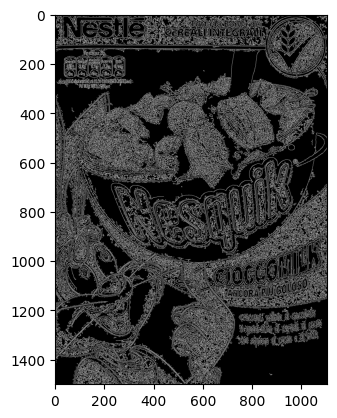

In [10]:
def adaptive_canny_threshold(image, ratio=2.0, kernel_size=3):
    # Calculate the gradient magnitude using Sobel operators
    grad_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=kernel_size)
    grad_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=kernel_size)
    grad_magnitude = cv.magnitude(grad_x, grad_y)

    # Compute dynamic thresholds based on gradient statistics
    median_grad = np.median(grad_magnitude)
    lower_threshold = max(0, int(median_grad / ratio))  # Avoid zero
    upper_threshold = int(median_grad * ratio)

    return lower_threshold, upper_threshold

# Example usage
image = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg', cv.IMREAD_GRAYSCALE)
low, high = adaptive_canny_threshold(image)

# Apply Canny edge detection with dynamic thresholds
edges = cv.Canny(image, low, high)
plt.imshow(edges, 'gray')
plt.show()

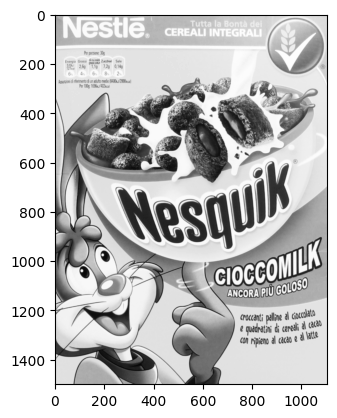

In [11]:
def adaptive_blur(image, threshold=100.0, max_blur_kernel=7):
    # Compute the Laplacian of the image
    laplacian = cv.Laplacian(image, cv.CV_64F)
    variance = laplacian.var()

    # Use the variance to adjust the Gaussian blur kernel size
    blur_kernel = 3  # Default kernel size

    if variance < threshold:
        # Increase blur for "blurry" images
        blur_kernel = min(max_blur_kernel, 2 * (variance // 10) + 1)

    # Apply Gaussian blur with the calculated kernel size
    return cv.GaussianBlur(image, (blur_kernel, blur_kernel), 1.5)

# Example usage
image = cv.imread('product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg', cv.IMREAD_GRAYSCALE)
adaptive_blurred_image = adaptive_blur(image)

plt.imshow(adaptive_blurred_image, 'gray')
plt.show()

In [14]:
# Load template and scene images
template_path = 'product-recognition-on-store-shelves-images/object_detection_project/models/0.jpg'
scene_path = 'product-recognition-on-store-shelves-images/object_detection_project/scenes/m2.png'  # Replace with your shelf scene image

#template_color = cv.imread(template_path, cv.IMREAD_COLOR)
#scene_color = cv.imread(scene_path, cv.IMREAD_COLOR)

# Convert to grayscale
#template_gray = cv.cvtColor(template_color, cv.COLOR_BGR2GRAY)
#scene_gray = cv.cvtColor(scene_color, cv.COLOR_BGR2GRAY)

template_gray = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)
#template_gray = cv.resize(template_gray, (350, 600), interpolation= cv.INTER_LINEAR)

# Preprocess with Gaussian blur and Canny edge detection
#template_blur = cv.GaussianBlur(template_gray, (5, 5), 1.5)
#scene_blur = cv.GaussianBlur(scene_gray, (5, 5), 1.5)

template_blur = adaptive_blur(template_gray)
scene_blur = adaptive_blur(scene_gray)

template_low, template_high = adaptive_canny_threshold(template_blur)
scene_low, scene_high = adaptive_canny_threshold(scene_blur)

template_edges = cv.Canny(template_blur, template_low, template_high)  # Tune thresholds
scene_edges = cv.Canny(scene_blur, 150, 200)
"""
plt.imshow(template_edges, 'gray')
plt.show()
plt.imshow(scene_edges, 'gray')
plt.show()

"""

# Initialize Generalized Hough Guil
ghg = cv.createGeneralizedHoughGuil()

# Set the template (template_edges and center)
template_center = (template_edges.shape[1] // 2, template_edges.shape[0] // 2)
ghg.setTemplate(template_edges, template_center)

# Restrict scale and angle ranges (optional)
#ghg.setScaleRange(0.8, 1.2)  # Adjust scale range (e.g., 80% to 120%)
#ghg.setAngleRange(-10, 10)   # Restrict rotation angles (in degrees)
#ghg.setMaxAngle(120)
#ghg.setMinAngle(80)
#ghg.setAngleStep(5)  # Larger step for faster runtime

#ghg.setAngleStep(4)          # Angular resolution step
#ghg.setScaleStep(0.1)  # Coarser scale resolution

# Detect the template in the scene
positions, votes = ghg.detect(scene_edges)
positions = positions[0]
votes = votes[0]

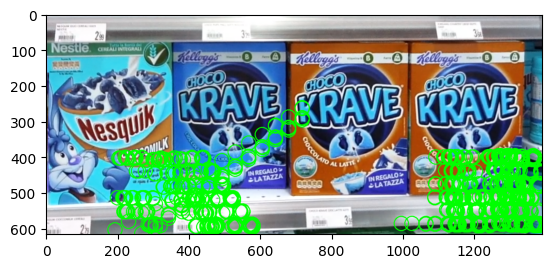

In [16]:
scene_color = cv.imread(scene_path, cv.IMREAD_COLOR)

# Filter detections by votes
min_votes = 200  # Set a threshold for minimum votes
#filtered_positions = [pos for pos, vote in zip(positions, votes) if vote >= min_votes]

filtered_positions = []
for i in range(0, len(positions)):
    if votes[i][0] >= min_votes:
        filtered_positions.append(positions[i])

# Draw detections on the scene
for position in filtered_positions:
    x, y, scale, angle = position
    cv.circle(scene_color, (int(x), int(y)), 20, (0, 255, 0), 2)  # Draw a circle at detected positions

# Show the result
plt.imshow(scene_color)
#cv.imshow("Detected Cereal Boxes", scene_color)
#cv.waitKey(0)
#cv.destroyAllWindows()